### The Goal:

The goal of this project is to implement a quantum calculator. We design a quantum circuit $U$ with the property that:

$$U \Ket{x}_d \Ket{y}_d \Ket{0}_d \Ket{z}_1 = \begin{cases} \Ket{x}_d \Ket{y}_d \Ket{x + y \mod 2^d}_d \Ket{z}_1 \text{ if } z=0 \\ \Ket{x}_d \Ket{y}_d \Ket{x \cdot y \mod 2^d}_d \Ket{z}_1 \text{ if } z=1 \end{cases} $$

Note that the circuit has some additional ancillary qubits. We implement this circuit using only elementary gates. Our implementation only uses arbitrary 1-qubit gates, CX gates and Toffoli gates. In addition, we benchmark the circuit for small values of $d$, and analyse the complexity of the circuit (in terms of number of gates, depth and ancillas) as $d \to \infty$. 

In [1]:
## We start with importing the necessary packages.

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
import numpy as np

In [2]:
## As a first step, we need to implement the Quantum Fourier Transform (QFT)

def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit

### Part 1: Designing the Quantum Adder circuit: 

Suppose there exists a circuit $A$, such that $A \Ket{x} \Ket{y}=\Ket{x}\Ket{x+y \mod 2^d}$. From here on, we will drop the $\mod 2^d$, and assume all addition is performed modulo $2$. We prove the following statement: 

**Lemma:** $A=(I \otimes IQFT) \circ e^{\frac{2 \pi i}{2^d} xy} \circ(I \otimes QFT) $. 

**Proof**: The proof is similar to Draper's Lemma. We use the fact that $A \circ (I \otimes IQFT) \Ket{x}\Ket{y}=\sum_{y'=0}^{2^d-1} e^{-\frac{2 \pi i}{2^d}y y'} \Ket{x} \Ket{y+x}$. Factoring out $e^{\frac{2 \pi i}{2^d} x y}$, we get that this is equal to $e^{\frac{2 \pi i}{2^d} x y} (I \otimes IQFT) \Ket{x} \Ket{y}$. Hence, we get that $A \circ(I \otimes IQFT) \Ket{x}\Ket{y}= e^{\frac{2 \pi i}{2^d} x y} (I \otimes IQFT) \Ket{x} \Ket{y}$. Postmultiplying on both sides by $(I \otimes QFT)$ proves this lemma.

Now, it is enough to implement the gate that takes $\Ket{x}\Ket{y}$ to $e^{\frac{2 \pi i}{2^d} x y} \Ket{x}\Ket{y}$. We now show that this can just be implemented using controlled phase shift gates (CP gates). 

$$e^{\frac{2 \pi i}{2^d} x y} \Ket{x}\Ket{y}=e^{\frac{2 \pi i}{2^d} \left(\sum_{j=0}^{d-1}x_j 2^j\right)\left(\sum_{k=0}^{d-1} y_k 2^k\right)} \Ket{x}\Ket{y} = \bigotimes_{j=0}^{d-1}\bigotimes_{k=0}^{d-1} e^{\frac{2 \pi i}{2^{d-j-k}}x_j y_k} \Ket{x_j}\Ket{y_k} \; .$$

Now, we design the Quantum Adder using qiskit's CP gate implementation. In the final version of the quantum calculator, we plan to implement this from scratch. 

### Phase shift subcircuit: 

**Input:** Any state vector $\Ket{x}_d \Ket{y}_d$ 

**Output:** $e^{2 \pi i xy/2^d} \Ket{x}_d \Ket{y}_d$(viewing $x$ and $y$ as $d$ bit integers). 

We start by noting that  $e^{2 \pi i xy/2^d} \Ket{x}_d \Ket{y}_d=\bigotimes_{j=0}^{d-1} \bigotimes_{k=0}^{d-1} e^{\frac{2 \pi i}{2^{d-j-k}}x_j y_k} \Ket{x_k} \Ket{y_k}$. Hence, it is enough to implement the unitary operation $\Ket{x}_1 \Ket{y}_1 \to U(0,0,\frac{2 \pi i}{2^{d-j-k}} x y) \Ket{x}_1\Ket{y}_1$

In [329]:
from numpy import pi
def PhaseShift(d,d1):
    #Adds a phase shift of e^(2 \pi i xy/2^d1)
    register_x=QuantumRegister(size=d, name="x")
    register_y=QuantumRegister(size=d, name="y")
    circuit=QuantumCircuit(register_x,register_y, name="Phase-Shift")
    for j in range(d):
        for k in range(d):
            theta=2 *np.pi/2**(d1-j-k)
            circuit.cp(theta, register_x[j], register_y[k], label=None, ctrl_state=None)
    return circuit
    

### Designing a quantum adder: 

We are now ready to design a quantum adder using the phase shift subcircuit, QFT and inverse QFT circuits. 

### Getting the output in the desired format. 

Recall that in the end, we need a circuit that takes $\Ket{x} \Ket{y} \Ket{0}_d$ to $\Ket{x} \Ket{y} \Ket{x + y \mod 2^d}$, while we have described a circuit that takes $\Ket{x} \Ket{y} $ to $\Ket{x} \Ket{x + y \mod 2^d}$. This can easily be remedied using a layer of CNOT gates before the QAdd circuit to copy the registers $y$ to the output registers.

In [305]:
def QuantumAdder(d):
    register_x = QuantumRegister(size=d, name="x")
    register_y = QuantumRegister(size=d, name="y")
    #register_control = QuantumRegister(size=1, name="control")
    register_out = QuantumRegister(size=d, name="output")
    circuit=QuantumCircuit(register_x,register_y, register_out, name="QAdd")
    for i in range(d):
        circuit.cx(register_y[i], register_out[i])
    circuit.barrier()
    PhaseShiftCircuit=PhaseShift(d,d)
    QFTCircuit=quantum_fourier_transform(d)
    QFTinvCircuit=inverse_quantum_fourier_transform(d)
    
    circuit.compose(QFTCircuit, qubits=register_out, inplace=True)   
    circuit.barrier()
    circuit.compose(PhaseShiftCircuit, qubits=register_x[:]+ register_out[:], inplace=True)
    circuit.barrier()
    circuit.compose(QFTinvCircuit, qubits=register_out[:], inplace=True)
    
    return circuit

We now print the circuit for $d=3$: 

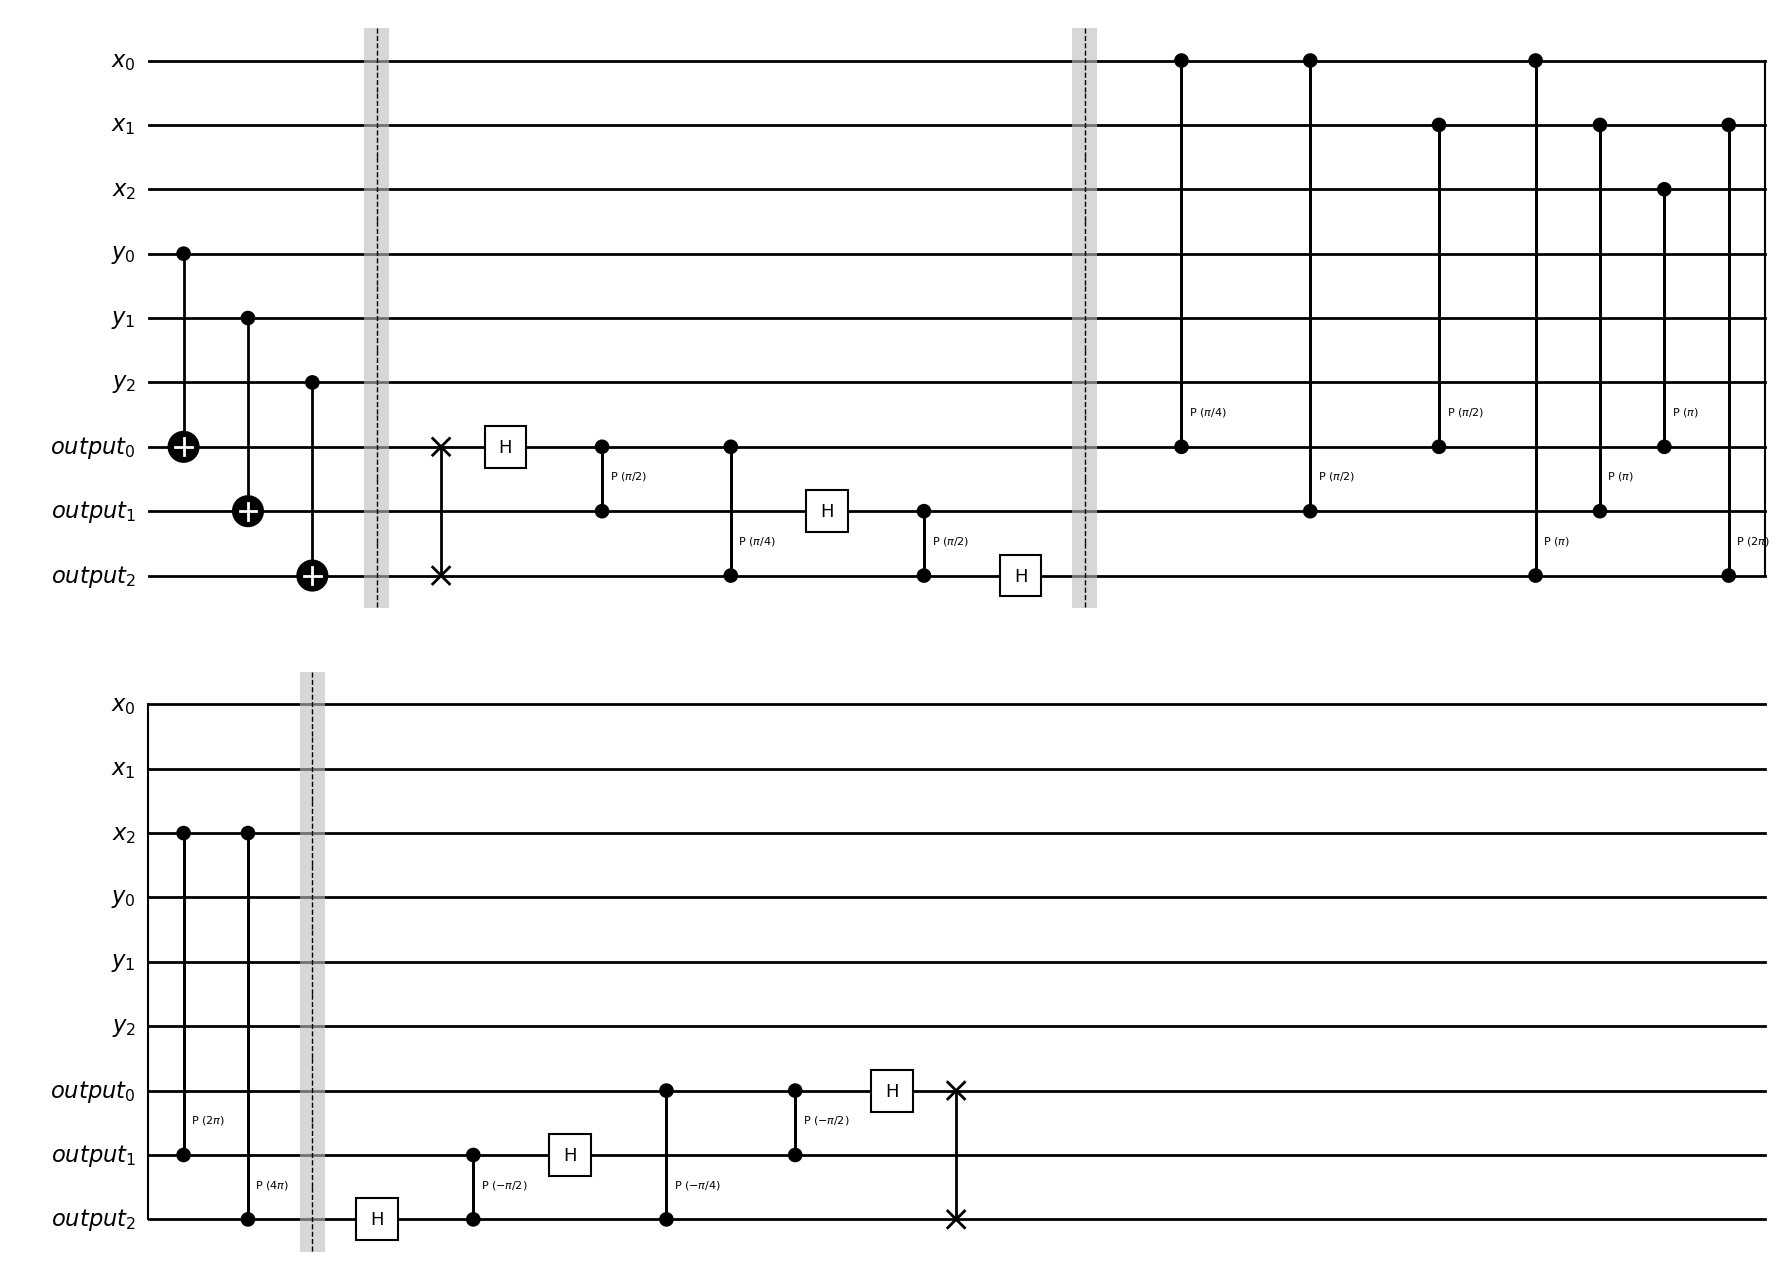

In [306]:
##Diagram of the quantum Adder circuit for $d=3$:
QAdd=QuantumAdder(3)
QAdd.draw(output="mpl", style="bw")

### Benchmarking the Quantum Adder: 

As a first step, we check that the quantum adder defined above works, and benchmark it. There was some confusion on my part regarding how qiskit encodes numbers. Suppose I want to add two 3 bit integers integers $a,b$, then I would want $x_0$ to encode the least significant bit of $a$, and $y_0$ to encode the least significant bit of $b$. In that case, I would pass as input to the above circuit the string $000 b_2 b_1 b_0 a_2 a_1 a_0$, and when we get the output state from qiskit we should expect the output to be $a+b,b,a$ (in binary)

We use $d=3$, and use the numbers $2=010$ and $4=100$. The sum should be $6=110$. We also check $4=100$ and $7=111$, and their sum should be $11 \mod 8 = 3 = 011$. Note that we have to feed the numbers in reverse to the calculator. 

In [301]:
###Example 1: a=2=010, b=4=100, a+b=6=110
## Define the circuit.
QAdd=QuantumAdder(3)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '000100010'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QAdd)
final_state.draw("Latex")

<IPython.core.display.Latex object>

In [302]:
###Example 2: a=7=111, b=1=001, a+b=8=000
## Define the circuit.
QAdd=QuantumAdder(3)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '000001111'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QAdd)
final_state.draw("Latex")

<IPython.core.display.Latex object>

### Part 2: A Quantum Multiplier: 

Our quantum multiplier simply performs repeated additions. Here, we design a circuit QMult that takes as input a state $\Ket{x}_d \Ket{y}_d \Ket{0}_d$ and outputs $QMult \Ket{x}_d \Ket{y}_d \Ket{0}_d=\Ket{x}_d \Ket{y}_d \Ket{x \cdot y\mod 2^d}_d$. Our circuit for multiplication essentially performs addition $d$ times, using the "high school" algorithm for multiplication. It consists of the following steps:

1. Perform a QFT operation on the $output$ register. 
2. Implement a controlled-phase shift subcircuit on the $x_0$, $y$ and output registers. On an input $\Ket{x_0} \Ket{y}_d \Ket{w}_d$, this performs a phase shift of $e^{\frac{2 \pi i x_0 yw}{2^d}}$ (we think of y and w as $d$-bit integers, and we also note that due to the QFT being performed on the output register, this is performed on a superposition of basis states) 
3. Implement a controlled-phase shift subcircuit on the $x_1$, $y$ and output registers, which perform a phase shift of $e^{\frac{2 \pi i x_1 yw}{2^{d-1}}}$.
6. $\dots$
7. controlled-phase shift subcircuit, with the inputs $y$, $output$, controlled by $x_{d-1}$ to perform a phase shift of $e^{\frac{2 \pi i x_1 yw}{2^{d-(d-1)}}}$
8. An inverse QFT on the output register

 Similar ideas have been employed in https://arxiv.org/pdf/1411.5949, although their circuits are significantly simplified and more efficient.

### A controlled phase shift subcircuit. 

Now we describe how to create a controlled phase shift subcircuit with with the inputs $y$, $output$, controlled by $x_j$. This uses $d$ ancilla qubits, $A_0, \dots, A_{d-1}$. Consider step 

1. for each $i=0,\dots, d-1$, add a Toffoli gate with inputs $x$ (the control), $y_i$ and  $A_i$.
2. Add a phase shift sibcircuit with inputs $output,A$ and with parameter $d-j$
 
### Number of Ancillas. 

It seems like in total, we would need $d$ ancilla registers with $d$ qubits each in total as we would need a fresh set of ancilla registers for each of the $d$ controlled phase shift subcircuits. 

### Number of gates. 

In [373]:
def QuantumMultiplier(d):
    register_x = QuantumRegister(size=d, name="x")
    register_y = QuantumRegister(size=d, name="y")
    register_out = QuantumRegister(size=d, name="output")
    ancilla_reg = AncillaRegister(size=d * d, name='anc')
    # Create 2D access list: ancilla[I][j] maps to ancilla_reg[I * d + j]
    ancilla = [[ancilla_reg[i * d + j] for j in range(d)] for i in range(d)]
    circuit=QuantumCircuit(register_x,register_y, register_out,ancilla_reg, name="QMult")
    ## QFT on output bits
    QFTCircuit=quantum_fourier_transform(d)
    circuit.compose(QFTCircuit, qubits=register_out, inplace=True)
    circuit.barrier()
    for i in range(d):
        for j in range(d):
            #Add Toffoli gate with inputs x_i, y_j, ancilla[i,j]
            circuit.ccx(register_x[i], register_y[j],ancilla[i][j])   
        circuit.barrier()
        #Phase shift subcircuit with parameter d-i
        PhaseShiftCircuit=PhaseShift(d,d-i)
        circuit.compose(PhaseShiftCircuit, qubits=register_out[:]+[ancilla[i][j] for j in range(d)], inplace=True)
        circuit.barrier()
    IQFTCircuit=inverse_quantum_fourier_transform(d)
    circuit.compose(IQFTCircuit, qubits=register_out, inplace=True)
    return circuit
    

### Benchmarking the quantum multiplier:

To start with, we prepare QMult for $d=2$. 

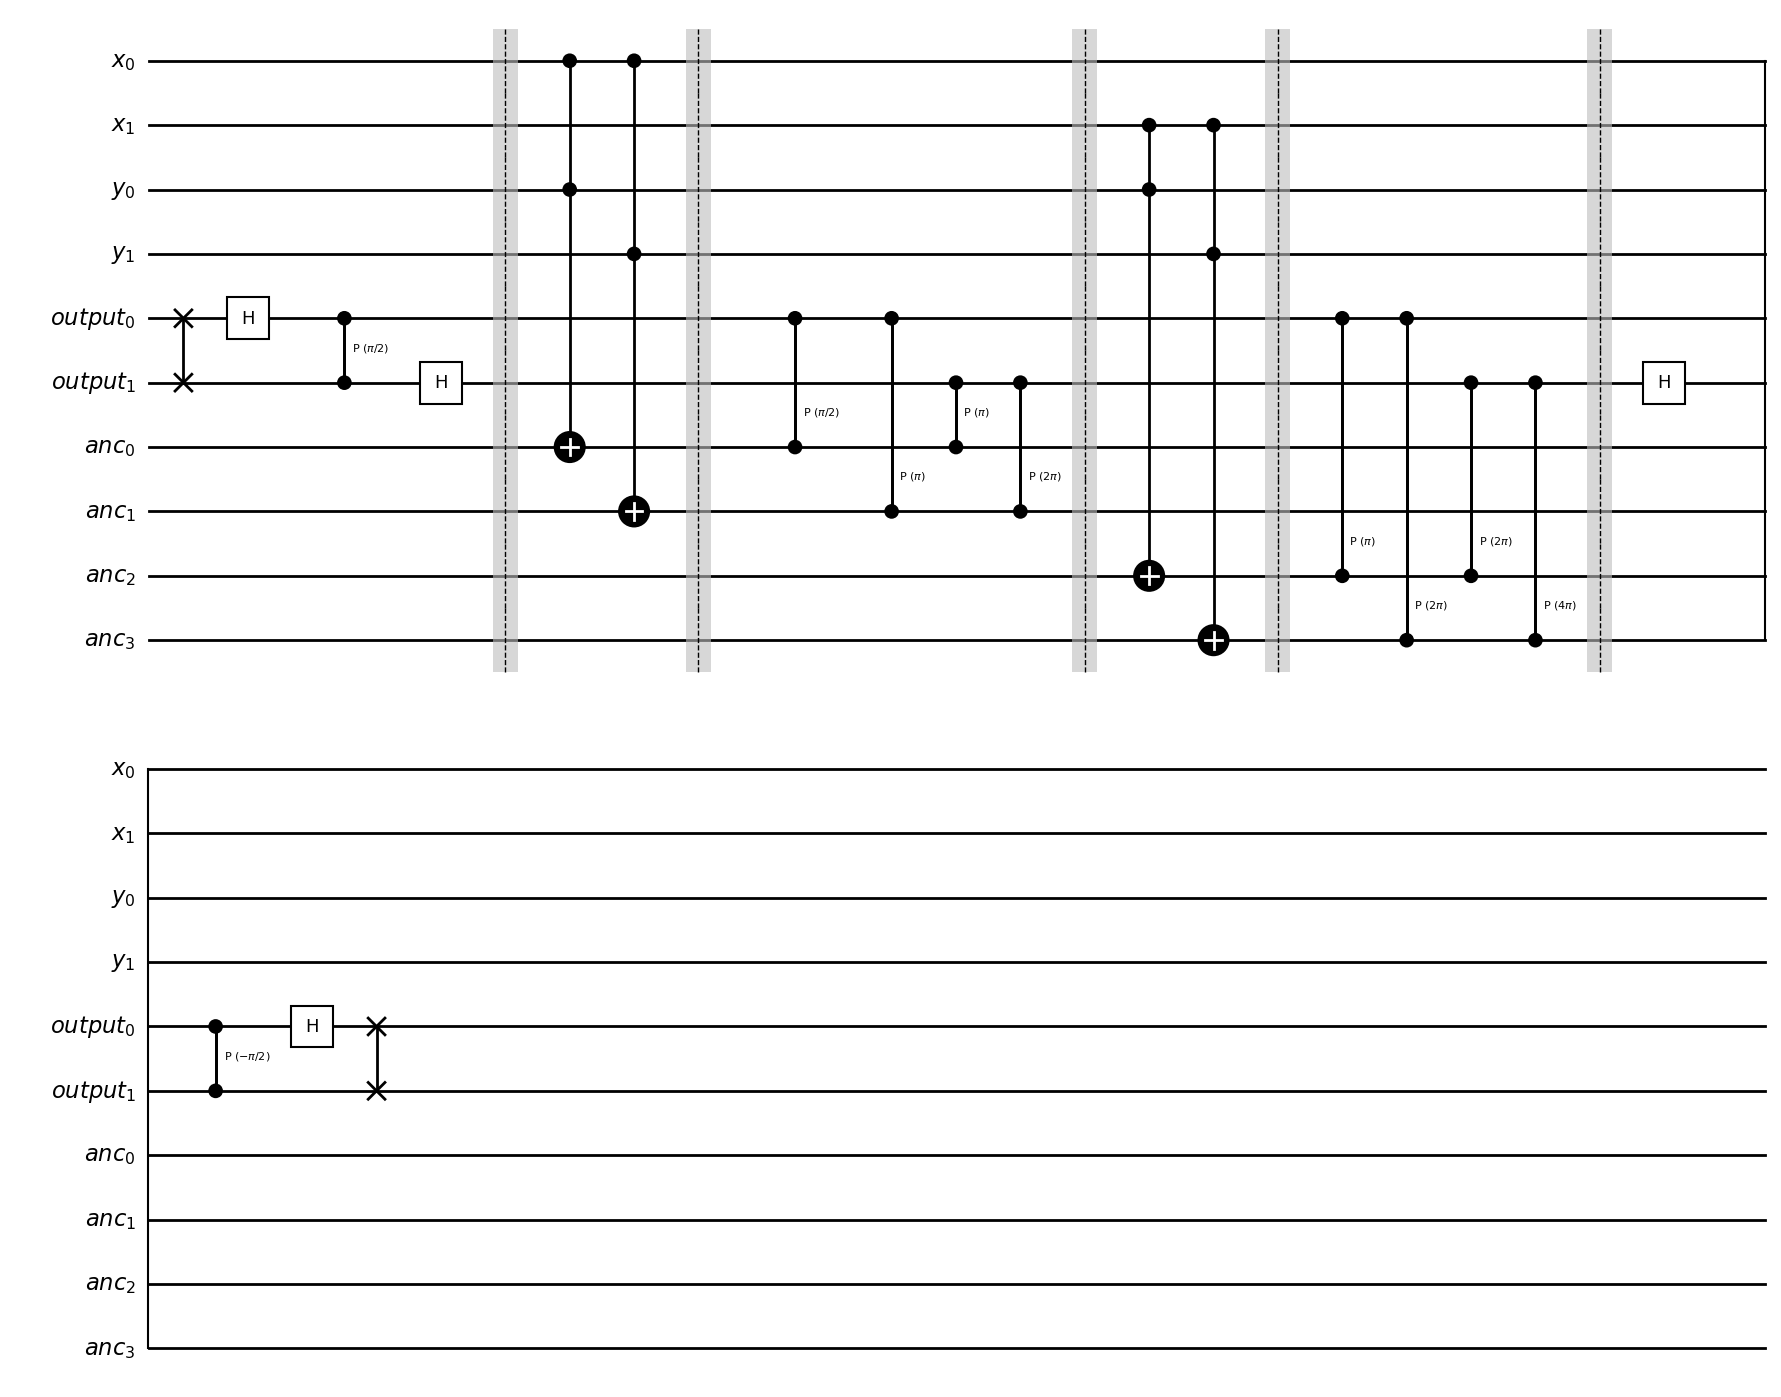

In [374]:
QMult=QuantumMultiplier(2)
QMult.draw(output="mpl", style="bw")

Consider the example of $a=1, b=1$. If the multipler is correct, we should get the output $01$ on the 5th and 6th registers from the right

In [387]:
###Example 1: a=1=01, b=1=01, a*b=1=01
## Define the circuit.
QMult=QuantumMultiplier(2)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '0000000101'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QMult)
final_state.draw("Latex")

<IPython.core.display.Latex object>

In [388]:
###Example 2: a=2=10, b=3=11, a*b=6=2=10
## Define the circuit.
QMult=QuantumMultiplier(2)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '0000001011'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QMult)
final_state.draw("Latex")

<IPython.core.display.Latex object>

In [389]:
###Example 3: a=3=11, b=3=11, a*b=9=1=01
## Define the circuit.
QMult=QuantumMultiplier(2)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '0000001111'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QMult)
final_state.draw("Latex")

<IPython.core.display.Latex object>

Next, we benchmark for $d=3$. consider $a=6=110$, $b=2=010$, $a*b=12=4=100$ Note the 7th,8th and 9th bits from the right. 

In [403]:
###Example 1: a=6=110, b=2=010, a*b=12=4=100
## Define the circuit.
QMult=QuantumMultiplier(3)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '000000000000110010'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QMult)
final_state.draw("Latex")

<IPython.core.display.Latex object>

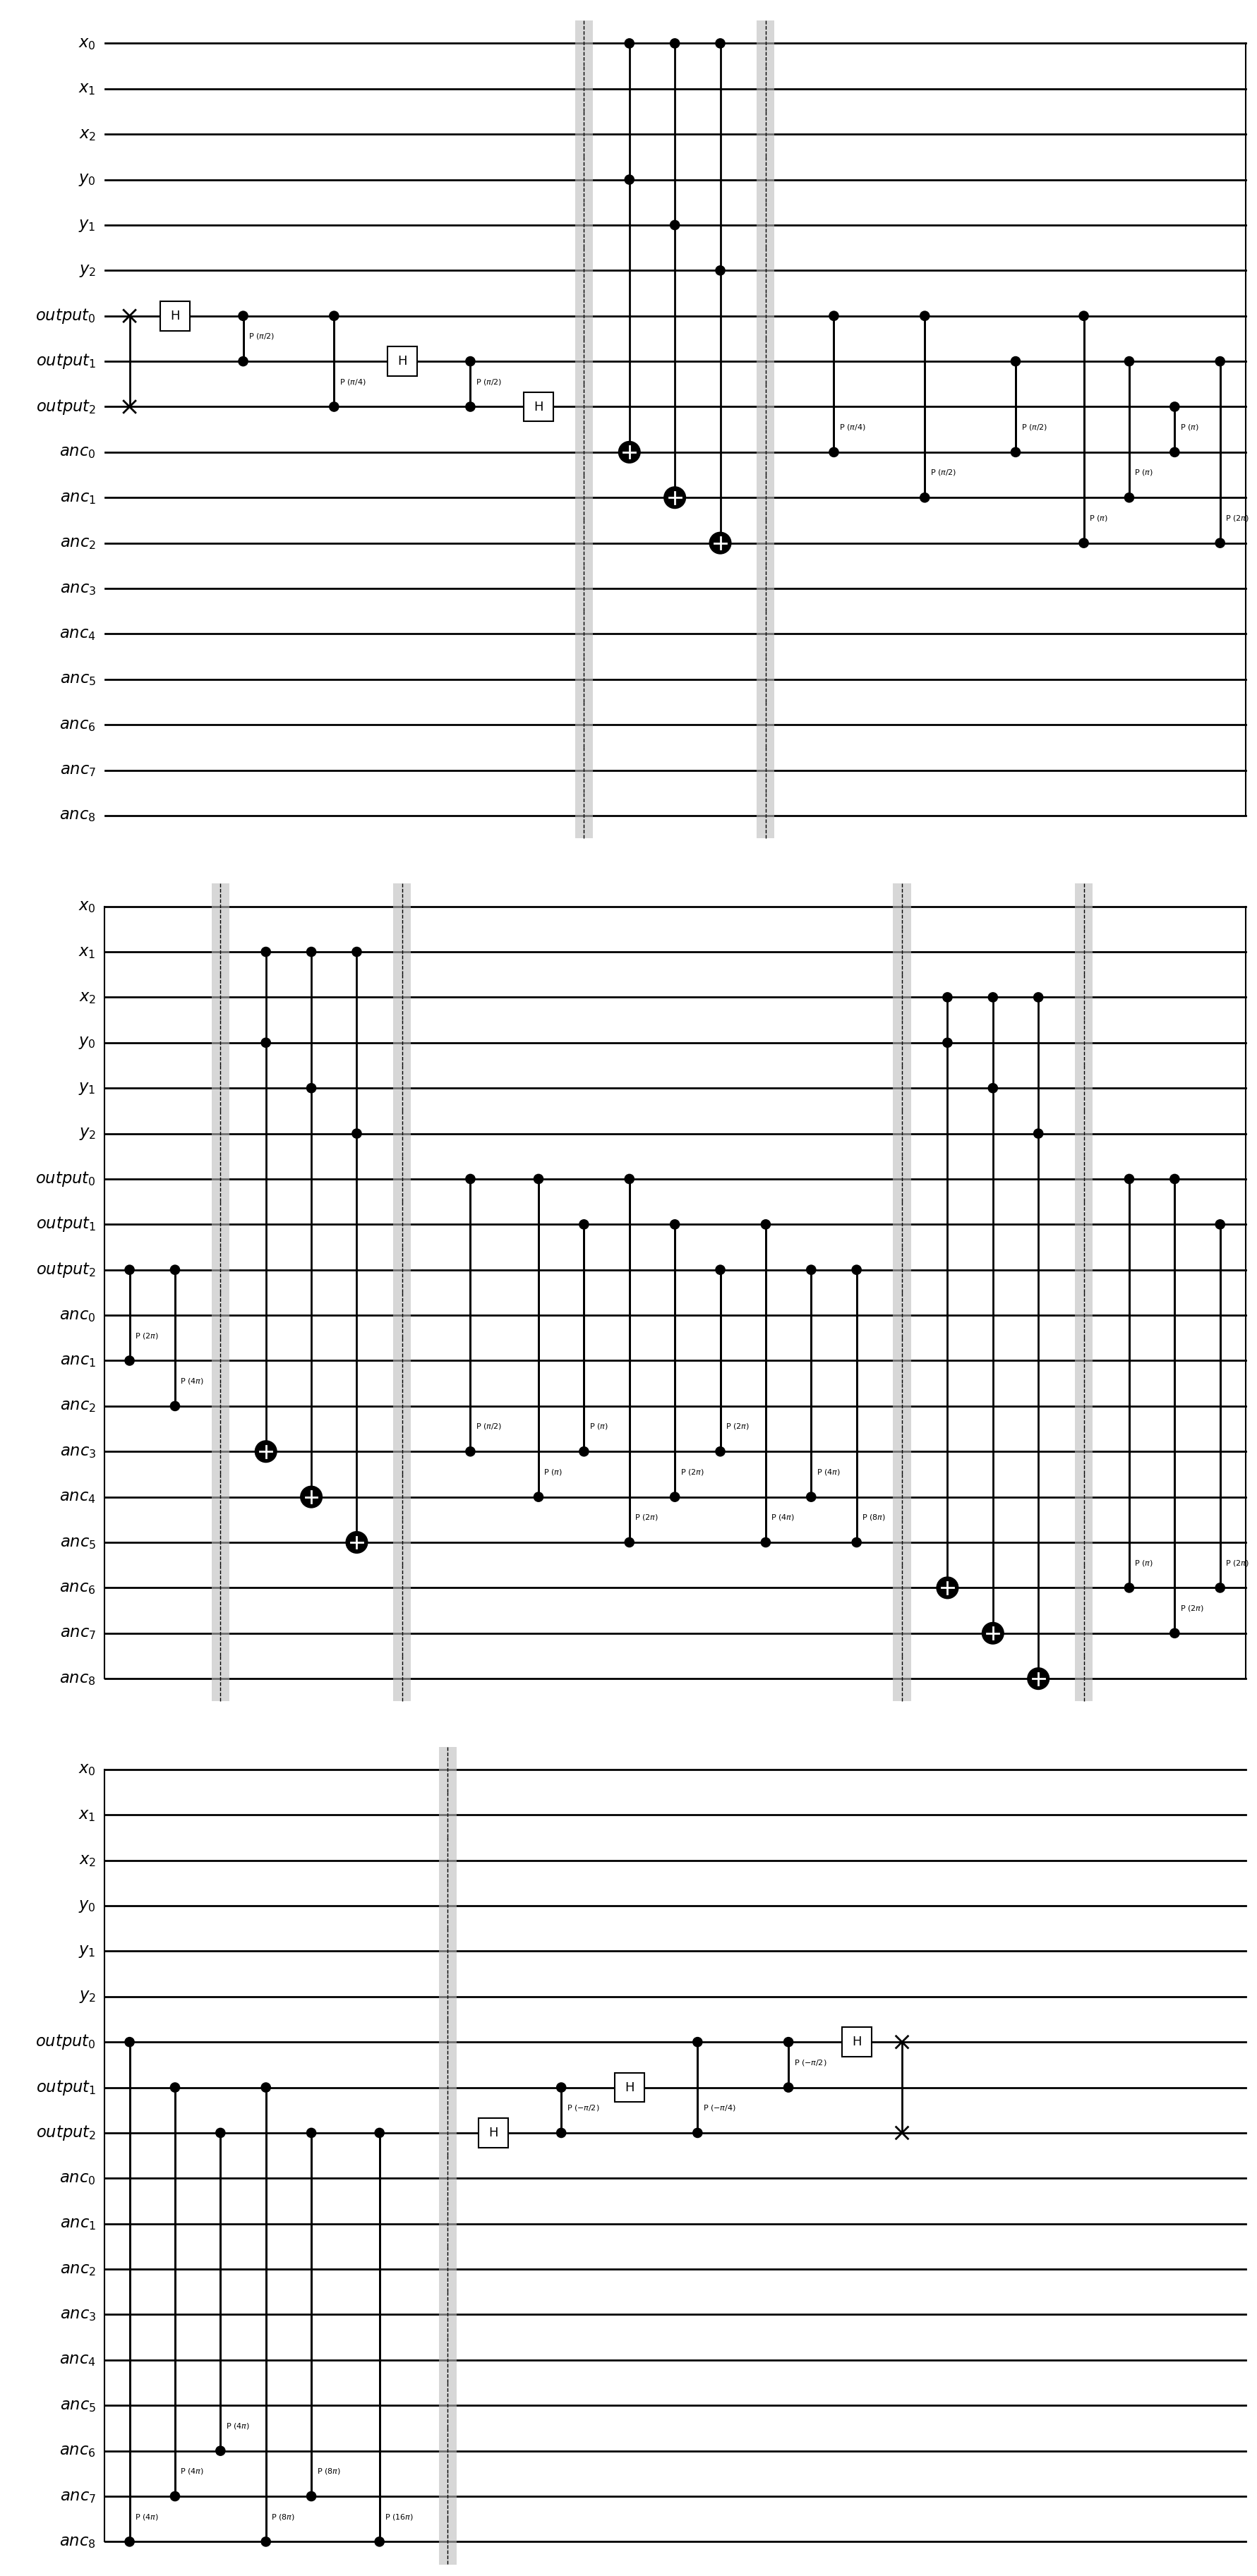

In [404]:
QMult.draw(output="mpl", style="bw")

### Part 3: A combined quantum calculator: 

Next, we just combine both the above circuits to create a quantum calculator. This is a simple design using ancillary qubits. First, we create two ancillary registers of size $d$ each, set to $0$. We run the circuit QAdd  on the registers $\Ket{x}, \Ket{y}$ and the first set of ancilla qubits and the circuit QMult on  the registers $\Ket{x}, \Ket{y}$ and the second set of ancilla qubits. Then, we copy the output of QMult to the output gate with doubly controlled X gates (controlled by the register $\Ket{z}$). Then, we apply an $X$ gate to $\Ket{z}$, and copy the output of QAdd to the output gate. Then, we apply an $X$ gate to $\Ket{z}$ again. 

In [ ]:
def QuantumCalculator(d):
    register_x = QuantumRegister(size=d, name="x")
    register_y = QuantumRegister(size=d, name="y")
    register_z = QuantumRegister(size=1, name="z")
    register_out=QuantumRegister(size=1, name="output")
    register_Mult_result = AncillaRegister(size=d, name="output of QMult")
    register_Add_result = AncillaRegister(size=d, name="output of QAdd")
    ancilla_reg = AncillaRegister(size=d * d, name='anc')
    #define the combined circuit:
    circuit=QuantumCircuit(register_x,register_y,register_z, register_out,register_Mult_result,register_Add_result,ancilla_reg  name="Quantum Calculator")
    #compose with QMult
    QMult=QuantumMultiplier(d)
    circuit.compose(QMult, qubits=register_x[:]+register_y[:]+register_Mult_result[:]+ancilla_reg[:], inplace=True)
    #compose with QAdd
    QAdd=QuantumAdder(d)
    circuit.compose(QAdd, qubits=register_x[:]+register_y[:]+register_Add_result[:], inplace=True)
    #copy output of QMult. 
    for i in range(d):
        circuit.ccx(z,register_Mult_result,register_out)
    circuit.x(z)
    #copy output of QAdd.
    for i in range(d):
        circuit.ccx(z,register_Add_result,register_out)
    #reset z gate.
    circuit.x(z)
    return circuit